# Analysis Code Group Behavior

In this experiment, 8 week old zebrafish were allowed to explore an open tank for 30 minutes in groups of n = 20. For tracking, the [TRex](https://www.trex.run/) software was used.

In [1]:
# Import packages
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import axes 
import matplotlib as mpl
import matplotlib.patches as mpatches
import seaborn as sns

import pickle
import pickle5 as pickle5

from scipy.spatial import distance, ConvexHull
from scipy.spatial.qhull import QhullError
from scipy import stats
from scipy.stats import ttest_ind, kstest, shapiro
from scipy.spatial.distance import cdist
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.stats.stats import pearsonr 

import math 
from math import inf

import random
import os 

## 1. Loading the data

Data is available from the EDMOND repository [Modulation of behavior in zebrafish by the neuropeptide PTH2](https://dx.doi.org/10.17617/3.6v). Individual data files should be placed within the same folder as the scripts, otherwise, file locations need to be updated in the cell below. 

The _collective behavior_ dataset is a [hierarchically indexed pandas dataframe](https://pandas.pydata.org/pandas-docs/stable/user_guide/advanced.html). The first level is the genotype (either $pth2^{-/-}$ or $pth2^{+/+}$). On the second level, there are five columns:

- **velocity**: median velocity of all individuals in pixels / frame
- **nearestneighbor**: median distance to the nearest fish for each frame in pixels
- **neighbor**: median distance to all other fish for each frame in pixels
- **neighbor_max**: median distance to the farthest fish for each frame in pixels
- **trajectory**: X- and Y-coordinates for all 20 fish for each frame (in pixels).

In [2]:
analysis_df = pd.read_pickle('.\\CollectiveBehavior_df.pkl')
a = inf 
analysis_df.replace(a, np.nan, inplace=True) # switch inf to nan
genotypes = analysis_df.index[[0]].levels[0][:] # get the list of genotypes (pth2-/- and pth2+/+)
cm_conversion = 100 / 49.624 # conversion factor to compute all values in cm instead of pixels
time = np.linspace(0,30,1799)  # for downsampling to 1 Hz

In [3]:
analysis_df.head()

velocity  \
$pth2^{+/+}$ 01  [555.1051726341248, 533.52845287323, 498.09267...   
             02  [366.9940187931061, 426.3455033302307, 412.858...   
             03  [392.94932413101196, 473.54088020324707, 435.8...   
             04  [372.45878982543945, 397.2716488838196, 390.39...   
             05  [282.0273332595825, 300.23718452453613, 310.45...   

                                                   nearestneighbor  \
$pth2^{+/+}$ 01  [1.0011866935864924, 1.6657515572726052, 1.522...   
             02  [1.0903456898172337, 1.224295065663659, 0.9962...   
             03  [1.020029478703396, 1.294428628425249, 1.76661...   
             04  [1.2762535578209055, 1.0123484837416408, 1.402...   
             05  [0.7913546066669566, 0.9973992250921725, 0.969...   

                                                          neighbor  \
$pth2^{+/+}$ 01  [5.061110099377002, 6.945467273172147, 7.10782...   
             02  [4.076560110703152, 3.9478100620394696, 3.7938...   
             03  [6.223177891627953, 9.805011402206016, 9.84375...   
             04  [5.715966072064976, 5.7810863104765025, 9.3586...   
             05  [3.7842832914288973, 4.027964475144868, 3.4815...   

                                                      neighbor_max  \
$pth2^{+/+}$ 01  [13.738487753044009, 15.057083892515251, 17.27...   
             02  [8.371035055915524, 8.431050249723949, 8.16357...   
             03  [16.492126899332384, 20.078000635314822, 18.72...   
             04  [11.867387545027931, 13.414244803756063, 18.96...   
             05  [6.961331610007361, 7.915136828199428, 8.73476...   

                                                        trajectory  
$pth2^{+/+}$ 01  [[[8.716231346130371, 20.40650749206543], [4.6...  
             02  [[[6.692618370056152, 19.471113204956055], [5....  
             03  [[[19.064956665039062, 19.617122650146484], [9...  
             04  [[[13.85396671295166, 23.045202255249023], [18...  
             05  [[[9.630776405334473, 11.863179206848145], [7....

## Figure 4 a
Example trajectories of 20 fish over one minute (wildtype in grey, mutants in green).

(-0.817702516913414,
 30.191914841532707,
 -0.4011478900909424,
 26.88944344520569)

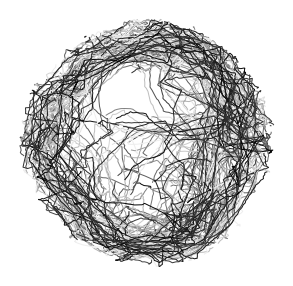

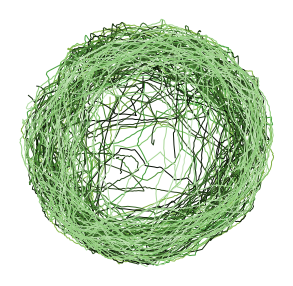

In [4]:
# example trajectories
fig, ax = plt.subplots(figsize = (5,5))
ax.set_prop_cycle(color=[
    
    '#464646' , '#525252' , '#5e5e5e' , '#6a6a6a' , '#767676',
    '#828282' , '#8e8e8e' , '#9a9a9a' , '#a6a6a6' , '#b2b2b2' , 
    '#bebebe' , '#cacaca' , '#d6d6d6' , '#e2e2e2' , '#eeeeee' ,
    '#0a0a0a' , '#161616' , '#222222', '#2e2e2e' , '#3a3a3a'
])
plt.plot(analysis_df['trajectory']['$pth2^{+/+}$'][13][0:1800,:,0] ,
         analysis_df['trajectory']['$pth2^{+/+}$'][13][0:1800,:,1], linewidth = 1)
ax.axis('off')

fig, ax = plt.subplots(figsize = (5,5))
ax.set_prop_cycle(color=[
    
    '#84c66c' , '#78c05d' , '#8bba4f' , '#81b045' , '#49a23f',
    '#519339' , '#080f06' , '#101d0b' , '#182c11' , '#203b17' , 
    '#29491d' , '#314822' , '#396728' , '#41762e' , '4b8835' ,
    '#c2e2b6' , '#b5dda7' , '#a9d798', '#9dd189' , '#90cc7b'
])


plt.plot(analysis_df['trajectory']['$pth2^{-/-}$'][0][0:1800,:,0] ,
         analysis_df['trajectory']['$pth2^{-/-}$'][0][0:1800,:,1], linewidth = 1)
ax.axis('off')

## Figure 4 b
The median velocity of the group was computed.

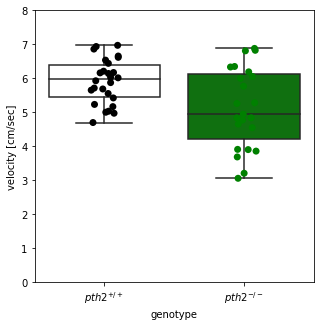

In [5]:
# extract velocity from dataset (easier indexing)
vel_df = analysis_df['velocity'].apply(pd.Series).transpose()
# replace infs with nans
a = inf 
vel_df.replace(a, np.nan, inplace=True)
# convert to cm/sec
vel_df = vel_df/(30*cm_conversion) 
# prepare dataframe suitable for seaborn plots

mat_dim = np.shape(vel_df.median())[0]
vel4plot = pd.DataFrame(np.zeros((mat_dim, 2)))
vel4plot.iloc[:,0] = vel_df.median().values
vel4plot.iloc[:,1] = np.hstack((np.repeat('$pth2^{+/+}$', 26),  np.repeat('$pth2^{-/-}$',23)))
vel4plot.columns = ["velocity", "genotype"]

fig, ax = plt.subplots(figsize = (5,5))
sns.boxplot(x="genotype", y="velocity", data=vel4plot, showfliers = 0 , palette=['w', 'g'])
sns.stripplot(x="genotype", y="velocity", data=vel4plot, size = 7, palette=['k', 'g'])
plt.ylim([0,8])
ax.set_xlabel('genotype')
ax.set_ylabel('velocity [cm/sec]')

t, p = ttest_ind(vel_df.median()['$pth2^{-/-}$'] , vel_df.median()['$pth2^{+/+}$'])

In [5]:
for genotype in ['$pth2^{-/-}$' , '$pth2^{+/+}$']:
    
    nVideos = len(analysis_df['trajectory'][genotype][:])
       
    for j in range (0, nVideos): 
        x = analysis_df.loc[genotype]['trajectory'][j][0:54000:30, :, :] # all coordinates from one video, downsampled to 1 Hz
        Frames = len(analysis_df['trajectory'][genotype][j][0:54000:30, 0, 0]) # n frames of current video, downsampled to 1 Hz
        
        if 'centroid_dict' not in locals():
            centroid_dict = {genotype: {j: centroid_position(x, Frames)}}
            
        elif genotype not in centroid_dict:
            centroid_dict[genotype] = {j: centroid_position(x, Frames)}
            
        else:
            centroid_dict[genotype][j] = centroid_position(x, Frames)

# convert centroid data to dataframe
centroid_df = pd.DataFrame.from_dict({i: centroid_dict[i]
                           for i in centroid_dict.keys() 
                           },
                       orient='index')

# get distance travelled by shoal
centroid_dist_df = centroid_df.transpose().copy(deep = True)

for genotype in ['$pth2^{-/-}$' , '$pth2^{+/+}$']:
    
    nVideos = len(analysis_df['trajectory'][genotype][:])
    
    for j in range(0 , nVideos):
        dist = np.sqrt(np.power(centroid_df.transpose()[genotype][j][1:,0] - centroid_df.transpose()[genotype][j][0:-1,0], 2) + 
               np.power(centroid_df.transpose()[genotype][j][1:,1] - centroid_df.transpose()[genotype][j][0:-1,1], 2))
        
        centroid_dist_df[genotype][j] = np.cumsum(dist)/cm_conversion

## Figure 4 c

Several distance measures are portrayed in the following graph:

[Text(0, 0.5, ''), (0.0, 13.0), Text(0.5, 0, 'distance [cm]')]

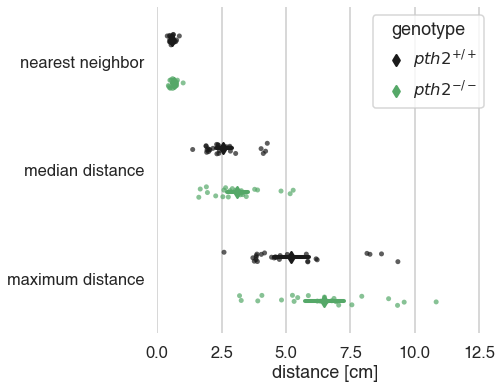

In [6]:
# build the dataframe for analysing distance between animals
nn_df = pd.melt(pd.DataFrame(analysis_df['nearestneighbor'].apply(pd.Series).transpose().median()/cm_conversion).transpose()).iloc[:,[0,2]]
nn_df.columns = ['genotype' , 'values']
nn_df['feature'] = pd.Series(np.repeat('nearest neighbor' , len(nn_df)))

mediandist_df = pd.melt(pd.DataFrame(analysis_df['neighbor'].apply(pd.Series).transpose().median()/cm_conversion).transpose()).iloc[:,[0,2]]
mediandist_df.columns = ['genotype' , 'values']
mediandist_df['feature'] = pd.Series(np.repeat('median distance' , len(mediandist_df)))

maxdist_df = pd.melt(pd.DataFrame(analysis_df['neighbor_max'].apply(pd.Series).transpose().median()/cm_conversion).transpose()).iloc[:,[0,2]]
maxdist_df.columns = ['genotype' , 'values']
maxdist_df['feature'] = pd.Series(np.repeat('maximum distance' , len(maxdist_df)))


df = pd.concat([nn_df, mediandist_df , maxdist_df], ignore_index=True) 

sns.set_theme(context='talk', style='whitegrid', palette='deep', font='helvetica', font_scale=1, color_codes=True, rc=None)
f, ax = plt.subplots(figsize = (6,6))
sns.despine(bottom=True, left=True)

# Show each observation with a scatterplot
sns.stripplot(x="values", y="feature", hue="genotype",
              data=df, dodge=True, alpha=.7, zorder=1 , palette=['k', 'g'])

# Show the conditional means
sns.pointplot(x="values", y="feature", hue="genotype",
              data=df, dodge=.4, join=False, 
              markers="d", scale=.75, ci=95 , palette=['k', 'g'])

# Improve the legend 
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[2:], labels[2:], title="genotype",
            handletextpad=0, columnspacing=1,
            loc="upper right", ncol=1, frameon=True)
ax.set(xlabel='distance [cm]', ylabel='',
        xlim = [0 , 13])

## Figure 4 d

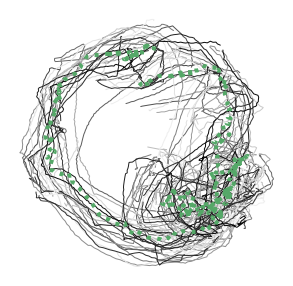

In [7]:
# example for trajectories with centroid movement overlaid
fig, ax = plt.subplots(figsize = (5,5))
ax.set_prop_cycle(color=[
    
    '#464646' , '#525252' , '#5e5e5e' , '#6a6a6a' , '#767676',
    '#828282' , '#8e8e8e' , '#9a9a9a' , '#a6a6a6' , '#b2b2b2' , 
    '#bebebe' , '#cacaca' , '#d6d6d6' , '#e2e2e2' , '#eeeeee' ,
    '#0a0a0a' , '#161616' , '#222222', '#2e2e2e' , '#3a3a3a'
])
plt.plot(analysis_df['trajectory']['$pth2^{+/+}$'][15][10000:10600,:,0] ,
         analysis_df['trajectory']['$pth2^{+/+}$'][15][10000:10600,:,1], linewidth = 1)
ax.axis('off')

plt.plot(np.nanmedian(analysis_df['trajectory']['$pth2^{+/+}$'][15][10000:10600,:,0], axis = 1) , 
         np.nanmedian(analysis_df['trajectory']['$pth2^{+/+}$'][15][10000:10600,:,1], axis = 1), 'g:' , linewidth = 4)

## Figure 4e: Correlation between polarization and correlation to centroid

In [8]:
# the second dataframe contains only the trajectories of the animals in a different form, more suitable for the ensuing analysis.
with open('.\\CollectiveBehavior_TrajectoriesOnly.pkl', 'rb') as file:
    # Call load method to deserialze
    analysis_df2 = pickle5.load(file)  
genotypes = analysis_df2.keys()

In [9]:
# PCA
def PCA_per_frame(video, get_variance): # DF, Bool
    video = video.dropna()
    df_processed = StandardScaler().fit_transform(video) 
    pca = PCA(n_components = 2) 
    principalComponents = pca.fit_transform(df_processed)
    principalDF = pd.DataFrame(data = principalComponents, columns = ['pc1', 'pc2'])    
    if get_variance == True: 
        return pca.explained_variance_ratio_
    else: 
        return principalDF

def get_centroid(video, pairs = False):
    temp = np.array([np.nanmean(video[:, ::2], axis = 1), np.nanmean(video[:, 1::2], axis = 1)])
    if pairs == False: 
        return temp
    else:
        return np.column_stack((temp[0], temp[1]))

def individualVScentroid(video, centroids):
    correlations = []
    for i in range(0, 20):
        correlation = np.array([pearsonr(centroids[:, 0], video[:, i*2]), pearsonr(centroids[:, 1], video[:, i*2 + 1])])
        correlations.append(correlation)
    return(correlations)  


xy_correlations =[]
variance = []
for i in range (0, len(genotypes)): 
    v = []
    xy_correlation =[]
    nVideos = analysis_df2[genotypes[i]].count()
    for j in range (0, nVideos): 
        # find variance explained  
        video = analysis_df2.iloc[j, i]
        v.append(PCA_per_frame(video, get_variance = True))
        # find trajectory correlation to centroid
        video = np.array(video)
        centroid = get_centroid(video, pairs = True)
        correlations = np.mean(individualVScentroid(video, centroid),axis = 0)
        x = correlations[0][0]
        y = correlations[1][0]
        xy_correlation.append((x + y) / 2) 
    xy_correlations.append(np.array(xy_correlation))
    v = np.sum(v, axis = 1) # sum variance explained of both pcs 
    variance.append(v)  
# sort variance by genotype
MT02KO_var = variance[0]
MT02WT_var = variance[1]

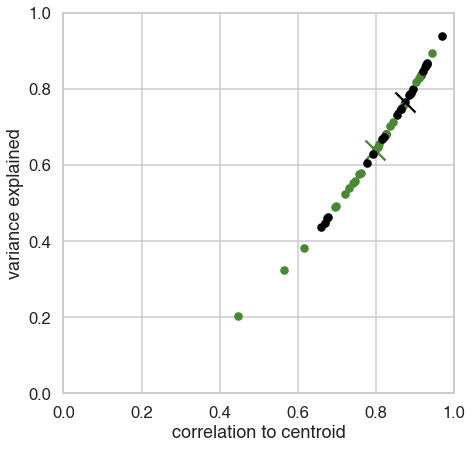

In [10]:
#### variance vs individual projectories centroid correlation plot ####
fig = plt.figure()
ax = plt.axes()
plt.ylabel('variance explained')
plt.xlabel('correlation to centroid')
plt.ylim(0, 1)
plt.xlim(0, 1)
fig.set_size_inches(7, 7)
KO_Median = np.median(xy_correlations[0])
WT_Median = np.median(xy_correlations[1])
for i in range(0, 23): 
    if not xy_correlations[0][i] == KO_Median:
        plt.scatter(xy_correlations[0][i], MT02KO_var[i], c = '#4b8835', s = 50, alpha = 1)
    else:
        plt.scatter(xy_correlations[0][i], MT02KO_var[i], marker = "x", c = '#4b8835', s = 400, alpha = 1)

    if not xy_correlations[1][i] == WT_Median:
        plt.scatter(xy_correlations[1][i], MT02WT_var[i], c = 'black', s = 50, alpha = 1)
    else:
        plt.scatter(xy_correlations[1][i], MT02WT_var[i], marker = "x", c = 'black', s = 50, alpha = 1)

plt.scatter(xy_correlations[1][23], MT02WT_var[23], c = 'black', s = 50, alpha = 1)
plt.scatter(xy_correlations[1][24], MT02WT_var[24], c = 'black', s = 50, alpha = 1)
plt.scatter(xy_correlations[1][25], MT02WT_var[25], marker = "x", c = 'black', s = 400, alpha = 1)
plt.show()

## Figure 4f: Variance explained as a measure of polarization

C:\Users\anneserl\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


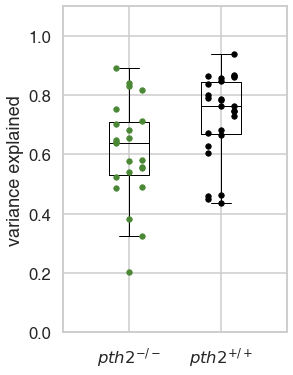

In [11]:
names = [ '$pth2^{-/-}$' , '$pth2^{+/+}$' ]
fig = plt.figure()
fig.set_size_inches(4, 6)
ax = plt.axes()
plt.ylim(0,1.1)
c = 'black'
plt.ylabel('variance explained')
bplot= plt.boxplot([variance[0], variance[1]], labels = ['$pth2^{-/-}$' , '$pth2^{+/+}$' ], positions = [1,1.7], showmeans = False, widths = (0.3,0.3), showfliers=False, patch_artist=False ,zorder=5  ,medianprops=dict(color=c))
x_1 = []
x_2 = []
for x in range (0, 10): 
    x_1.append(0.9)
    x_1.append(1)
    x_1.append(1.1)
    x_2.append(1.6)
    x_2.append(1.7)
    x_2.append(1.8)
x_1 = x_1[:len(variance[0])]
x_2 = x_2[:len(variance[1])]

# plot individual data points    
for x, y in zip(x_1, variance[0]):
    plt.scatter(x, y, alpha=1, s = 30, marker = "o", facecolors='#4b8835', edgecolors='#4b8835',zorder=10,linewidths=0.8)
for x, y in zip(x_2, variance[1]):
    plt.scatter(x, y, alpha=1, s = 30, marker = "o", facecolors='black', edgecolors='black',zorder=10,linewidths=0.8)
plt.show()

## Excursion Analysis

In [19]:
# function that finds simple NND or NNDn - NNDn-1 to account for different excursion subgroups 
def NND(video, n = 1):
    output = []
    for i in range(0, len(video)):  
        x = np.array(np.split(video[i], 20)) # get frame by frame 
        all_values = cdist(x, x) # pairwise euclidean distances between all fish within that frame 
        all_values[all_values == 0] = np.nan # 0 -> nan
        
        if n > 1: 
            nth_NN= np.partition(all_values, n-1, axis = 0)[n-1] #NNDn 
            nth_NN1= np.partition(all_values, n-2, axis = 0)[n-2] #NNDn-1
            output.append(nth_NN - nth_NN1)
        else:
            NN = np.nanmin(all_values, axis = 1) # find min excluding nan i.e. NND
            output.append(NN)   
    return output

# recursive function that corrects wrong excursions by checking if there is a fish nearby that is not on an 
# excursion. Nearby means within range of threshold that was calculated for excursion type 1 (i.e. the one used
# to identify single fish splitting from the group)
# f = current frame
# all_values = all distances between all fish 
# fish_indx = index of the fish that is investigated in that frame 
# threshold = taken from excursion type 1
# bi = 
# to_correct = index of fish that are on a wrong excursion during that frame
#blacklist = fish that have already been checked within this function call
def recursion(f, all_values, fish_indx, threshold, bi, to_correct, blacklist):
    blacklist.append(fish_indx) 
    fish_neighbors = all_values[fish_indx].copy() # get distances only from current fish
    to_correct.append(fish_indx)
    NN_indx = np.where(fish_neighbors == np.nanmin(fish_neighbors))[0]
    temp_blacklist = np.array(blacklist)
    # find NND indx of a fish that has not been checked yet
    for i in range(0, 19):
        if len(temp_blacklist[temp_blacklist == NN_indx]) > 0:
            NN_indx = np.where(fish_neighbors == np.partition(fish_neighbors, i + 1)[i+1])[0]
        else: 
            break
    # the next neighbor is far away so it was a correct excursion of that individual/group
    if fish_neighbors[NN_indx] > threshold: 
        return bi

    # the next neighbor is close by AND NOT an outlier. Therefore, this was not a true excursion
    elif bi[NN_indx] == False and fish_neighbors[NN_indx] < threshold:
        bi[np.array(to_correct)] = 0
        return bi

    # the next neighbor is close by AND IS an outlier. Therefore, we need to check this next neighbor.
    elif bi[NN_indx] == True and fish_neighbors[NN_indx] < threshold:
        
        recursion(f, all_values, NN_indx[0], threshold, bi, to_correct, blacklist)
        return bi

FINAL_OUTPUT = []
for s in range (0, len(genotypes)): 
    FINAL = []
    nVideos = analysis_df2[genotypes[s]].count()
    for a in range (0, nVideos): 
        video = np.array(analysis_df2.iloc[a,s])
        if not np.nansum(video) == 0: 
            ## NND and mode of NND across all fish
            chunks = 1 # initially I thought it might work better when you split the video and calculate thresholds for each chunk. 
            all_thresh = []
            split_video = np.array(np.split(video, chunks))
            final_excursions = []
            for l in range(0, chunks): 
                video = split_video[l]
                excursions_time = []
                segments_time = []
                for g in range(0, 10):  # get NND and find mode for each subgroup size. (N/2)
                    NN = NND(video, g+1)
                    NN = np.array(NN)
                    flatNND = np.concatenate(NN)
                    mode = stats.mode(flatNND)[0][0]
                    # get segments where NND is above mode per individual 
                    max_all = []
                    for i in range(0, 20): # 20 fish ofc
                        array = np.append(NN[:,i], -np.inf)  
                        mask = array < mode  # values to be removed
                        split_indices = np.where(mask)[0]
                        output = []
                        for subarray in np.split(array, split_indices + 1):
                            if len(subarray > 1):   
                                output.append(subarray[:-1]) 
                        array=np.array(output)
                        segments = np.array([y for y in array if 0 not in y.shape]) # drop empty arrays
                        #find max NND for each segment 
                        maxes = []
                        for j in range(0, len(segments)): 
                            maxes.append(np.amax(segments[j]))
                        max_all.append(np.array(maxes))
                    # calculate thresh of actual excursions 
                    flat_max = np.concatenate(max_all)
                    real_thresh = np.quantile(flat_max, 0.985) # 0.985 empirically determined 
                    if g == 0:
                        all_thresh.append(real_thresh)
                    time_excursion = []
                    segments = []
                    # now that we have our final threshold we can actually look for segments that are above thresh
                    for i in range(0, 20):
                        temp = NN[:,i]
                        time_excursion.append(temp > real_thresh)
                        array = np.append(NN[:,i], -np.inf)  
                        mask = array < real_thresh  # values to be removed
                        split_indices = np.where(mask)[0]
                        output = []
                        for subarray in np.split(array, split_indices + 1):
                            if len(subarray > 2):   
                                output.append(subarray[:-1]) 
                        array=np.array(output)
                        segments.append(np.array([y for y in array if 0 not in y.shape])) # drop empty arrays
                    time_excursion = np.array(time_excursion)
                    excursions_time.append(time_excursion)
                    segments_time.append(np.array(segments))
                final_excursions.append(np.array(excursions_time))
            final_excursions = np.array(final_excursions)
            # binarize excursions. A fish is either on any type of excursion or not 
            excursion_binary = []
            for l in range(0, chunks):
                excursion_sum = np.sum(final_excursions[l], axis = 0)
                tempp = []
                for i in range(0, 20):
                    where = np.where(excursion_sum[i] > 0)
                    temp = np.zeros(int(54000/chunks))
                    temp[where] = 1
                    tempp.append(temp)
                excursion_binary.append (np.array(tempp))
            excursion_binary = np.array(excursion_binary)
            excursion_binary=(np.concatenate(excursion_binary, axis = 1))
            # recursively check for wrong excursions. An excursion is wrong if there is a fish nearby that is not
            # on an excursion
            empty = np.empty(54000)
            empty = np.split(empty, chunks)
            for i in range (0, chunks ): # for when you have multiple threshold because you split the video 
                empty[i].fill(all_thresh[i]) # threshold for excursion type 1
            final_binary = []
            all_thresh = np.concatenate(empty)
            # recursively correcting wrong excursions 
            for i in range(0, 54000):
                f = video[i]
                x = np.array(np.split(f, 20)) # get frame by frame 
                all_values = cdist(x, x) # pairwise euclidean distances between all fish within that frame 
                all_values[all_values == 0] = np.nan # 0 -> nan
                threshold = all_thresh[i] # threshold for excursion type 1
                binary = []
                blacklist = []
                to_correct = []
                bi = excursion_binary[:, i].copy()
                for j in range(0, 20):
                    blacklist = []
                    to_correct = []
                    if excursion_binary[j, i] == True:
                        binary.append(recursion(f, all_values, j, threshold, bi, to_correct, blacklist))
                binary = [x for x in binary if x is not None]
                temp = np.zeros(20)
                if len(binary) > 0:
                    where = np.where(np.sum(binary, axis = 0) == len(binary))[0]
                    temp[where] = 1
                final_binary.append(temp)
            final_binary = np.array(final_binary)   
            # exclude excursions that last less than a second (30 frames)
            for k in range(0, 20):
                Flag = False 
                thresh = 30
                n = 0
                for i in range(0, len(final_binary)):  
                    if final_binary[i, k]== 1 and Flag == False: # first one is found 
                        Flag = True 
                        n +=1
                    elif final_binary[i, k] ==1 and Flag == True: #consec is found 
                        n +=1
                    elif final_binary[i, k] == 0 and Flag == True: # last one is found 
                        if n < thresh:
                            for j in range(1, n+1):
                                final_binary[i - j, k] = False 
                        n = 0
                        Flag = False
            FINAL.append(final_binary)   
    FINAL_OUTPUT.append(FINAL)
    
# ANALYSIS of data 

def consecutive(data, stepsize=1):
    return np.split(data, np.where(np.diff(data) != stepsize)[0]+1)

n_excursions = []
time_excurisons = []
participants_excursions = []
participants_over_time = []
mean_excursion_time = []
for i in range (0, len(FINAL_OUTPUT)): 
    n_ex = []
    t_ex = []
    p_ex = []
    Mean_excursion_time = []
    part_over_time = []
    for j in range (0, len(FINAL_OUTPUT[i])): 
        output_arr = np.array(FINAL_OUTPUT[i][j])
        
        flat = output_arr > 0 
        sum_flat = np.sum(flat, axis = 1) 
        flat = np.where(sum_flat > 0) # get frames where there is at least one fish on an excursion
        ind_excursions = consecutive(flat[0])# find consecutive frames to determine independet excursions 
        excursion_dur = []
        for k in range(0, len(ind_excursions)):
            excursion_dur.append(len(ind_excursions[k]))
        
        n_ex.append(len(ind_excursions)) # number of excursions  
        t_ex.append(len(flat[0])) # total time of excursions
        Mean_excursion_time.append(np.mean(excursion_dur)) #duration of excursions
        sm = np.nansum(output_arr, axis = 1)
        # distribution of excursion participants 
        tt = sm.copy()
        sm[sm == 0] = np.nan 
        sum_mean = np.nanmean(sm)
        p_ex.append(sum_mean)
        where = np.where(tt > 0)
        excursions = tt[where]
        x = np.histogram(excursions, bins = 20)
        total = np.sum(x[0])
        fraction = x[0] / total
        part_over_time.append(fraction)
        
    n_excursions.append(n_ex)
    time_excurisons.append(t_ex)
    participants_excursions.append(p_ex)
    participants_over_time.append(np.array(part_over_time))
    mean_excursion_time.append(Mean_excursion_time)


C:\Users\anneserl\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:75: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
C:\Users\anneserl\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
C:\Users\anneserl\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:99: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. 

## Figure 4g: Number of excursions

C:\Users\anneserl\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


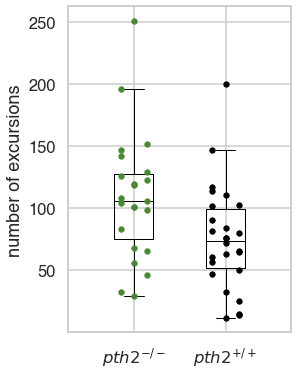

In [20]:
# Number of excursions
fig = plt.figure()
fig.set_size_inches(4, 6)
ax = plt.axes()
plt.ylabel('number of excursions')
x_1 = []
x_2 = []
c = 'black'
bplot= plt.boxplot([n_excursions[0] , 
                    n_excursions[1]] ,  
                    positions = [1,1.7] , 
                    labels = ['$pth2^{-/-}$' , '$pth2^{+/+}$' ] , 
                    showmeans = False, 
                    widths = (0.3,0.3) , 
                    showfliers=False ,
                    zorder=5  ,
                    medianprops=dict(color=c))
for x in range (0, 10): 
    x_1.append(0.9)
    x_1.append(1)
    x_1.append(1.1)
    x_2.append(1.6)
    x_2.append(1.7)
    x_2.append(1.8)
x_1 = x_1[:len(n_excursions[0])]
x_2 = x_2[:len(n_excursions[1])]
# plot individual data points    
for x, y in zip(x_1, n_excursions[0]):
    plt.scatter(x, y, alpha=1, s = 30, marker = "o", facecolors='#4b8835', edgecolors='#4b8835', zorder=10 ,linewidths=0.8)
for x, y in zip(x_2, n_excursions[1]):
    plt.scatter(x, y, alpha=1, s = 30, marker = "o", facecolors='black', edgecolors='black', zorder=10,linewidths=0.8)

## Figure 4h: Total excursion time

C:\Users\anneserl\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


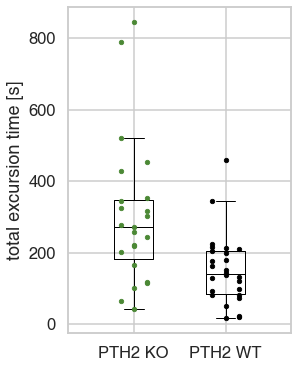

In [21]:
# time on excursion 
fig = plt.figure()
fig.set_size_inches(4, 6)
ax = plt.axes()
plt.ylabel('total excursion time [s]')
x_1 = []
x_2 = []
c = 'black'
bplot= plt.boxplot([ np.array(time_excurisons[0])/30, np.array(time_excurisons[1])/30],  positions = [1,1.7], labels = ['PTH2 KO', 'PTH2 WT'], showmeans = False, widths = (0.3,0.3), showfliers=False,zorder=5  ,medianprops=dict(color=c))
for x in range (0, 10): 
    x_1.append(0.9)
    x_1.append(1)
    x_1.append(1.1)
    x_2.append(1.6)
    x_2.append(1.7)
    x_2.append(1.8)
x_1 = x_1[:len(n_excursions[0])]
x_2 = x_2[:len(n_excursions[1])]
# plot individual data points    
for x, y in zip(x_1, np.array(time_excurisons[0])/30):
    plt.scatter(x, y, alpha=1, s = 20, marker = "o", facecolors='#4b8835', edgecolors='#4b8835', zorder=10 ,linewidths=0.8)
for x, y in zip(x_2, np.array(time_excurisons[1])/30):
    plt.scatter(x, y, alpha=1, s = 20, marker = "o", facecolors='black', edgecolors='black', zorder=10,linewidths=0.8)

## Figure 4i

In [39]:
# pre-allocate dataframe for PCA:
df = np.empty((len(analysis_df['velocity']) , 6))
df = pd.DataFrame(df)
df.columns = ['velocity' , 'velocity IQR' , 'NN distance' , 'average distance' , 'centroid speed' ,  'convex hull area']
df.index = analysis_df.index

In [40]:
# load data for convex hull
hull_df = pd.read_pickle('.\\hull_df.pkl')
genotypes = analysis_df.index[[0]].levels[0][:]
## use the code below to re-create the dataset loaded above

#hull_df = analysis_df['trajectory'].copy(deep = True)
#for genotype in genotypes:
#    for video in range(0,len(analysis_df['trajectory'][genotype])):
#        hull_area = np.repeat(np.nan, 1800)
#        for i in range(0,1800):
#            points = analysis_df['trajectory'][genotype][video][i*30,:,0], analysis_df['trajectory'][genotype][video][i*30,:,1]
#            points = np.array(pd.DataFrame(points).transpose().dropna())
#            try:
#                hull = ConvexHull(points)
#                hull_area[i] = hull.area
#            except QhullError:
#                hull_area[i] = np.nan
#            except ValueError:
#                hull_area[i] = np.nan
#        hull_df[genotype][video] = hull_area

In [41]:
# populate dataframe
for genotype in genotypes:
    for video in range(0, len(analysis_df['velocity'][genotype])):
        x = np.array(analysis_df['velocity'][genotype][video])
        x[x == inf] = np.nan
        df['velocity'][genotype][video] = np.nanmedian(x)
        q75, q25 = np.percentile(x[~np.isnan(x)], [75 ,25])
        df['velocity IQR'][genotype][video] = q75 - q25
        
        x = np.array(analysis_df['nearestneighbor'][genotype][video])
        x[x == inf] = np.nan
        df['NN distance'][genotype][video] = np.nanmedian(x)
        
        x = np.array(analysis_df['neighbor'][genotype][video])
        x[x == inf] = np.nan
        df['average distance'][genotype][video] = np.nanmedian(x)
        
        # shoal centroid speed
        df['centroid speed'][genotype][video] = np.nanmedian(centroid_dist_df[genotype][video])
        
        # hull area
        df['convex hull area'][genotype][video] = np.nanmedian(hull_df[genotype][video])        

In [42]:
# scale features in dataframe

scaler = MinMaxScaler()
df[['velocity' , 'velocity IQR' , 'NN distance' , 'average distance' , 'centroid speed', 'convex hull area'  ]] = scaler.fit_transform(df[['velocity' , 'velocity IQR' , 'NN distance' , 'average distance' , 'centroid speed', 'convex hull area'  ]])
lut = dict(zip(range(0,3), "kg"))
row_colors = pd.Series(np.array(df.index.codes[0])).map(lut)

In [43]:
# perform principal component analysis

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(df)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
targets = dict(zip(range(0,3), genotypes[0:3]))
principalDf['genotype'] = pd.Series(df.index.codes[0]).map(targets)

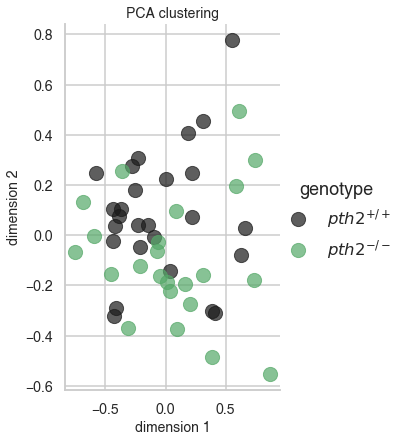

In [44]:
# plot
sns.lmplot(x = 'principal component 1', y = 'principal component 2' , data = principalDf ,
          fit_reg = False ,
          legend = True ,
          hue = 'genotype' ,
          height = 6 ,
          aspect = 0.7 ,
          scatter_kws = {'s': 200 , 'alpha':0.7} ,
           palette=['k', 'g'])
plt.title('PCA clustering' , weight = 'bold').set_fontsize(14)
plt.xlabel('dimension 1' , weight = 'bold').set_fontsize(14)
plt.ylabel('dimension 2' , weight = 'bold').set_fontsize(14)

## Figure 4j

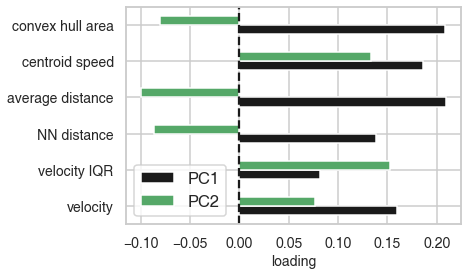

In [45]:
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
loading_matrix = pd.DataFrame(loadings, columns=['PC1', 'PC2'], index=df.columns)
plt.rc('xtick',labelsize=14)
plt.rc('ytick',labelsize=14)
ax = loading_matrix.plot.barh(rot = 0 , color=['k' , 'g'])
ax.axvline(0, color='k', linestyle='--')
ax.set_xlabel('loading').set_fontsize(14)


## Extended Data Figure 3d

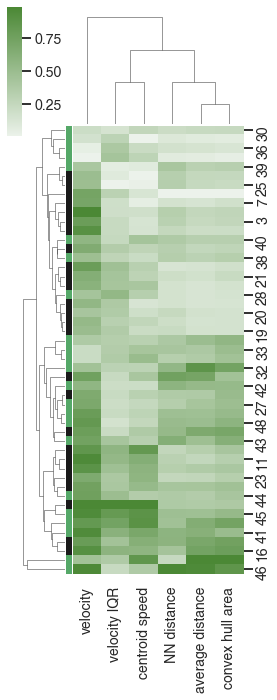

In [47]:
# plot 
sns.clustermap(df.reset_index(drop=True), robust=True , row_colors = row_colors , figsize = (4, 10) , cmap=sns.color_palette("light:#4b8835" , as_cmap = True)) 
sns.color_palette("light:#4b8835" , as_cmap = True)

## Extended Data Figure 3e

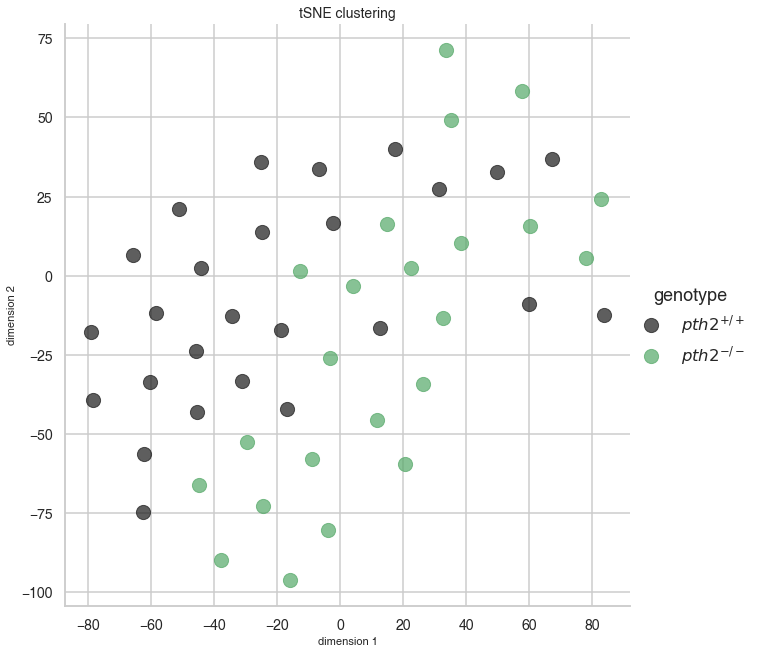

In [48]:
X_embedded = TSNE(n_components=2 , random_state = 28).fit_transform(df)
X_df = pd.DataFrame(X_embedded)
X_df['genotype'] = pd.Series(df.index.codes[0]).map(targets)
X_df.columns = ['dim1' , 'dim2' , 'genotype']

sns.lmplot(x = 'dim1', y = 'dim2' , data = X_df ,
          fit_reg = False ,
          legend = True ,
          hue = 'genotype' ,
          height = 9 ,
          scatter_kws = {'s': 200 , 'alpha':0.7}, 
          palette=['k', 'g'])
plt.title('tSNE clustering' , weight = 'bold').set_fontsize(14)
plt.xlabel('dimension 1' , weight = 'bold').set_fontsize(11)
plt.ylabel('dimension 2' , weight = 'bold').set_fontsize(11)

# Extended Data Figure 3a

Ttest_indResult(statistic=-2.237867551473434, pvalue=0.030007411907046033)

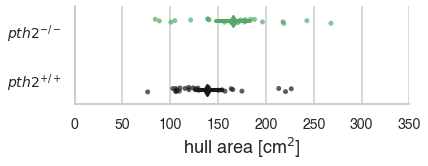

In [49]:
cm_conversion_area = (100 / 49.624) * (100 / 49.624)

hull_area = hull_df.apply(pd.Series).transpose()
hull_df = hull_area.median()
hull_df = pd.DataFrame(hull_df)
df_concat = hull_df.transpose()['$pth2^{-/-}$'].transpose()
df_concat['genotype'] = np.repeat('$pth2^{-/-}$', len(df_concat))

df_concat2 = hull_df.transpose()['$pth2^{+/+}$'].transpose()
df_concat2['genotype'] = np.repeat('$pth2^{+/+}$', len(df_concat2))

df = pd.concat([df_concat, df_concat2], ignore_index=True) 
df.columns = ['hull area' , 'genotype']
df['hull area'] = df['hull area'] * cm_conversion_area

f, ax = plt.subplots(figsize = (6,1.8))
sns.despine(right = True)

# Show each observation with a scatterplot
sns.stripplot(x="hull area", y="genotype", hue="genotype",
                data=df, dodge=True, alpha=.7, zorder=1 , palette=['g', 'k'])

# Show the conditional means
sns.pointplot(x="hull area", y="genotype", hue="genotype",
                data=df, dodge=.40, join=False, 
                markers="d", scale=.75, ci=95 , palette=['g', 'k'])

# Improve the legend 
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[2:], labels[2:], title="genotype",
            handletextpad=0, columnspacing=1,
            bbox_to_anchor=(1,1), ncol=1, frameon=True)
ax.set(xlabel='hull area [cm$^2$]', ylabel='' , xlim = [0 , 350])
        
ax.get_legend().remove()

ttest_ind(df[df['genotype'] == '$pth2^{+/+}$']['hull area'] ,
          df[df['genotype'] == '$pth2^{-/-}$']['hull area'])

## Extended Data Figure 3b

Ttest_indResult(statistic=-0.05081549173208697, pvalue=0.9596878979990561)

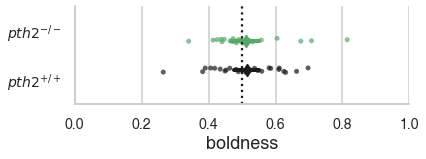

In [50]:
# empirically determined dimensions of tank
max_param_x = 29.16
min_param_x = 0.67
max_param_y = 25.82
min_param_y = 0.65
center = [(max_param_x - min_param_x) / 2 , (max_param_y - min_param_y) / 2]

def boldness(video):
    return np.sum(np.sqrt(np.power((video[:,:,0]-center[0]) , 2) + np.power((video[:,:,1]-center[1]) , 2)) > 9.485) /(54000*20)  # 9.458 is the radius of the inner zone of the tank, as defined in the methods section.
boldness_df = analysis_df['trajectory'].copy(deep = True)    
# compute parameter
for genotype in genotypes:
    for video in range(0,len(analysis_df['trajectory'][genotype])):
        boldness_df[genotype][video] = boldness(analysis_df['trajectory'][genotype][video])
        


# reconstruct dataframe for plotting
bold_df = pd.melt(pd.DataFrame(boldness_df)['trajectory'].apply(pd.Series).transpose()).iloc[:,[0,2]]
bold_df.columns = ['genotype' , 'values']

f, ax = plt.subplots(figsize = (6,1.8))
sns.despine(right = True)

# Show each observation with a scatterplot
sns.stripplot(x="values", y="genotype", hue="genotype",
                data=bold_df, dodge=True, alpha=.7, zorder=1 , palette=['k', 'g'] , order=['$pth2^{-/-}$', '$pth2^{+/+}$'])

# Show the conditional means
sns.pointplot(x="values", y="genotype", hue="genotype",
                data=bold_df, dodge=.40, join=False, palette=['k', 'g'],
                markers="d", scale=.75, ci=95 , order=['$pth2^{-/-}$', '$pth2^{+/+}$'])

# Improve the legend 
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[2:], labels[2:], title="genotype",
          handletextpad=0, columnspacing=1,
          bbox_to_anchor=(1,1), ncol=1, frameon=True)
ax.set(xlabel='boldness', ylabel='',
        xlim = [0 , 1])
ax.get_legend().remove()
plt.axvline(0.5, 0 , 1, color = 'k' , linestyle = ':')
    
ttest_ind(bold_df[bold_df['genotype'] == '$pth2^{-/-}$']['values'] , 
          bold_df[bold_df['genotype'] == '$pth2^{+/+}$']['values'] )

## Extended Data Figure 3c

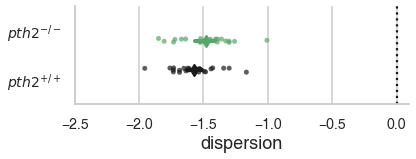

In [33]:
# dispersion was computed as in Harpaz et al., 2021: dispersion = log (NN / NN_shuffled). Shuffled distance were calculated by drawing 20 fish positions from random timepoints within a video
NN_shuffled = 2.76 # shuffled nearest-neighbor distance
nn_df['dispersion'] = np.log(nn_df['values'] / NN_shuffled)

f, ax = plt.subplots(figsize = (6,1.8))
sns.despine(right=True)

# Show each observation with a scatterplot
sns.stripplot(x="dispersion", y="genotype", hue="genotype",
              data=nn_df, dodge=True, alpha=.7, zorder=1 , order=['$pth2^{-/-}$', '$pth2^{+/+}$'] , palette=['k', 'g'])

# Show the conditional means
sns.pointplot(x="dispersion", y="genotype", hue="genotype",
              data=nn_df, dodge=.4, join=False, palette=['k', 'g'],
              markers="d", scale=.75, ci=95 , order=['$pth2^{-/-}$', '$pth2^{+/+}$'])

# Improve the legend 
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[2:], labels[2:], title="genotype",
          handletextpad=0, columnspacing=1,
          ncol=1, frameon=True)
ax.set(xlabel='dispersion', ylabel='',
       xlim = [-2.5, 0.1])
ax.get_legend().remove()

plt.axvline(0, 0 , 2, color = 'k' , linestyle = ':')